Task 4: Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

Assumptions based on the Task 4 that I am making here is:

(i.) task is to analyse and visualize 'sentiment' only for the specific brand (i.e. Game in the CSV), So, I will not be dropping null/empty 'tweet_content' as they still contain notnull sentiments which will help in overall analysis of user preferences.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Load datasets
train_df = pd.read_csv('twitter_training.csv')
val_df = pd.read_csv('twitter_validation.csv')

In [ ]:
see_train = train_df.head(3)
see_val = val_df.head(3)
see_train, see_val

(   Tweet_ID       entity sentiment  \
 0      2401  Borderlands  Positive   
 1      2401  Borderlands  Positive   
 2      2401  Borderlands  Positive   
 
                                        tweet_content  
 0  im getting on borderlands and i will murder yo...  
 1  I am coming to the borders and I will kill you...  
 2  im getting on borderlands and i will kill you ...  ,
    Tweet_ID     entity   sentiment  \
 0      3364   Facebook  Irrelevant   
 1       352     Amazon     Neutral   
 2      8312  Microsoft    Negative   
 
                                        tweet_content  
 0  I mentioned on Facebook that I was struggling ...  
 1  BBC News - Amazon boss Jeff Bezos rejects clai...  
 2  @Microsoft Why do I pay for WORD when it funct...  )

In [ ]:
train_df.columns

Index(['Tweet_ID', 'entity', 'sentiment', 'tweet_content'], dtype='object')

In [ ]:
train_df = train_df.drop(columns=['Tweet_ID'])
val_df = val_df.drop(columns=['Tweet_ID'])

In [ ]:
train_null = train_df.isnull().sum()
train_unique = train_df.nunique()
# In validation set
val_null = val_df.isnull().sum()
val_unique = val_df.nunique()
print("training set:")
print("train_null: ", train_null, "\ntrain_unique: ", train_unique)

print("\n\nValidation set:")
print("val_null: ", val_null, "\nval_unique: ", val_unique)


training set:
train_null:  entity             0
sentiment          0
tweet_content    686
dtype: int64 
train_unique:  entity              32
sentiment            4
tweet_content    69489
dtype: int64


Validation set:
val_null:  entity           0
sentiment        0
tweet_content    0
dtype: int64 
val_unique:  entity            32
sentiment          4
tweet_content    999
dtype: int64


In [ ]:
print("tweet_content Dtype:", train_df['tweet_content'].dtype)
print("tweet_content Dtype:", val_df['tweet_content'].dtype)

tweet_content Dtype: object
tweet_content Dtype: object


In [ ]:
train_df['tweet_content'] = train_df['tweet_content'].astype('string')
val_df['tweet_content'] = val_df['tweet_content'].astype('string')

In [ ]:
print(train_df['tweet_content'].apply(type).head())

0    <class 'str'>
1    <class 'str'>
2    <class 'str'>
3    <class 'str'>
4    <class 'str'>
Name: tweet_content, dtype: object


In [ ]:
# Using nlp.pipe for faster processing
train_df['tokenized_tweet'] = list(nlp.pipe(train_df['tweet_content'].fillna("No Comment").astype(str), batch_size=1000))
val_df['tokenized_tweet'] = list(nlp.pipe(val_df['tweet_content'].fillna("No Comment").astype(str), batch_size=1000))

In [ ]:
# Process data
X = train_df[['entity','tweet_content']]
y = train_df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Irrelevant': 2})  # Encode sentiment

In [ ]:
# Applying TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=9000)
X_train_tfidf = vectorizer.fit_transform(train_df['tweet_content'])
X_valid_tfidf = vectorizer.transform(val_df['tweet_content'])

In [ ]:
#Train Test Split
X_train_tfidf, X_valid_tfidf, y_train, y_valid = train_test_split(X_train_tfidf,
                                                                  train_df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Irrelevant': 2}),
                                                                  test_size=0.2, random_state=42)


In [ ]:
# Checking if number of rows match
print(X_train_tfidf.shape)
print(y_train.shape)


(59745, 9000)
(59745,)


In [ ]:
print(train_df.isnull().sum())  # Checking for missing values in the original dataset


entity             0
sentiment          0
tweet_content      0
tokenized_tweet    0
dtype: int64


In [ ]:
# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
# Model Training
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict on the validation set
y_pred = lr_model.predict(X_valid_tfidf)

In [ ]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

Accuracy:  0.7336145142933654
Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.82      0.79      4519
           0       0.70      0.70      0.70      3596
           1       0.73      0.77      0.75      4230
           2       0.73      0.58      0.65      2592

    accuracy                           0.73     14937
   macro avg       0.73      0.72      0.72     14937
weighted avg       0.73      0.73      0.73     14937



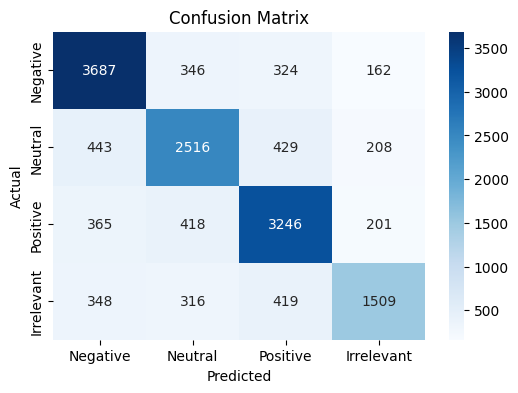

In [ ]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'], yticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

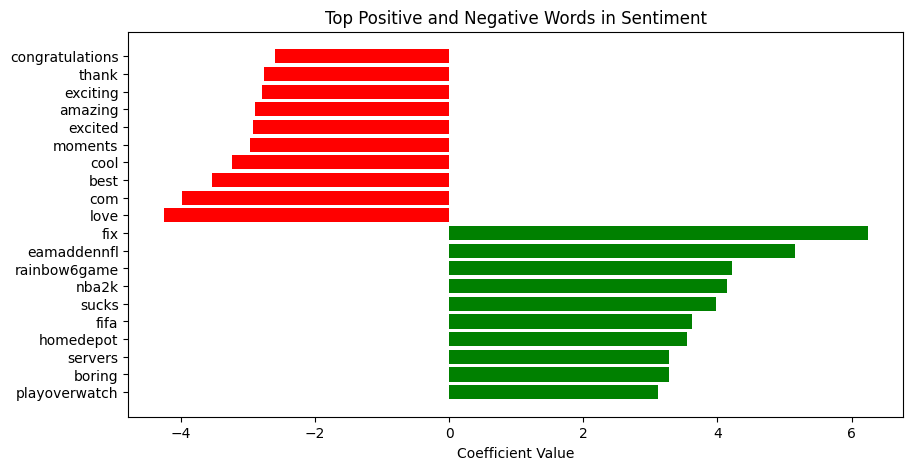

In [ ]:
# Get the coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names = vectorizer.get_feature_names_out()

# Sort the coefficients to see the most important features (words)
sorted_idx = coefficients.argsort()

# Top 10 positive and negative words
top_positive_words = [feature_names[i] for i in sorted_idx[-10:]]
top_negative_words = [feature_names[i] for i in sorted_idx[:10]]

# Plot the coefficients (positive and negative words)
plt.figure(figsize=(10, 5))
plt.barh(top_positive_words, coefficients[sorted_idx[-10:]], color='green', label='Positive')
plt.barh(top_negative_words, coefficients[sorted_idx[:10]], color='red', label='Negative')
plt.xlabel('Coefficient Value')
plt.title('Top Positive and Negative Words in Sentiment')
plt.show()


In [ ]:
#Hyperparameter tuning using GridSearchCV although it have been done earlier, but is used afterwards to show the changes and contrast.
from sklearn.model_selection import GridSearchCV

# parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # regularization
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'C': 100, 'solver': 'liblinear'}


In [ ]:
# Retrain the model using the best hyperparameters
best_lr_model = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_lr_model.predict(X_valid_tfidf)

print("Accuracy with best parameters: ", accuracy_score(y_valid, y_pred_best))
print("Classification Report (Best Model):\n", classification_report(y_valid, y_pred_best))


Accuracy with best parameters:  0.795072638414675
Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.83      0.83      0.83      4519
           0       0.77      0.77      0.77      3596
           1       0.77      0.82      0.80      4230
           2       0.80      0.72      0.76      2592

    accuracy                           0.80     14937
   macro avg       0.79      0.79      0.79     14937
weighted avg       0.80      0.80      0.79     14937



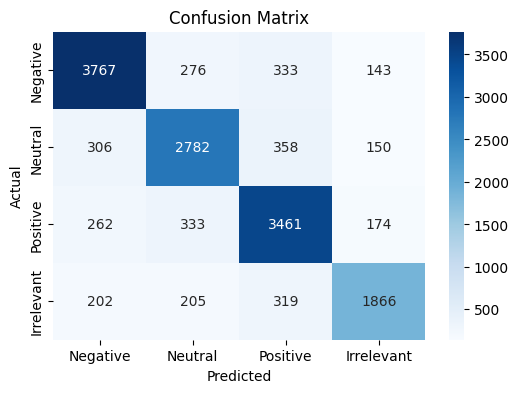

In [ ]:
# Confusion Matrix Visualization after GrdiSearchCV
conf_matrix = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'], yticklabels=['Negative', 'Neutral', 'Positive', 'Irrelevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

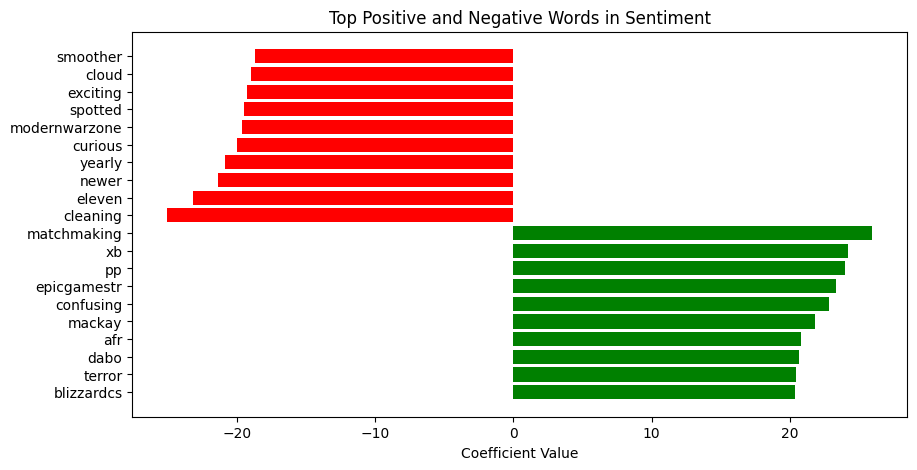

In [ ]:
coefficients = best_lr_model.coef_[0]
feature_names = vectorizer.get_feature_names_out()
sorted_idx = coefficients.argsort()

# Top 10 positive and negative words
top_positive_words = [feature_names[i] for i in sorted_idx[-10:]]
top_negative_words = [feature_names[i] for i in sorted_idx[:10]]

plt.figure(figsize=(10, 5))
plt.barh(top_positive_words, coefficients[sorted_idx[-10:]], color='green', label='Positive')
plt.barh(top_negative_words, coefficients[sorted_idx[:10]], color='red', label='Negative')
plt.xlabel('Coefficient Value')
plt.title('Top Positive and Negative Words in Sentiment')
plt.show()


In [ ]:
# Save the preprocessed val_df for download
val_df.to_csv('new_twitter_validation.csv', index=False)

Given below is a user prompt where the user will copy-paste the tokenized_tweet from this file which will be visible in content panel (left side of the screen) called 'new_twitter_validation.csv'.

Guide:

1. open the new validation file.

2. it will be visible on the right side of the screen.

3. select a tweet and copy it as it is and paste it as the 'user_input' after running the cell.

4. it will predict a sentiemnt usning the hyperparameter tuned model i.e. best_lr_model.
5. check the predicted sentiment against the actual sentiment in the currently opened file (right panel).

In [ ]:
while True:
    user_input = input("Enter a tweet from the validation set for sentiment prediction: \n")
    user_input_tfidf = vectorizer.transform([user_input])

    # Predicting sentiment using the trained model
    predicted_sentiment = best_lr_model.predict(user_input_tfidf)

    # Map back the prediction to sentiment labels
    sentiment_map = {1: 'Positive', 0: 'Neutral', -1: 'Negative', 2: 'Irrelevant'}
    predicted_label = sentiment_map.get(predicted_sentiment[0], 'Unknown')

    print(f"The predicted sentiment for the entered tweet is: {predicted_label}")
    continue_input = input("Do you want to enter another tweet? (yes/no): ")
    if continue_input.lower() != 'yes':
        print("Goodbye!")
        break


Enter a tweet from the validation set for sentiment prediction: 
Hi @EAHelp I’ve had Madeleine McCann in my cellar for the past 13 years and the little sneaky thing just escaped whilst I was loading up some fifa points, she took my card and I’m having to use my paypal account but it isn’t working, can you help me resolve it please?
The predicted sentiment for the entered tweet is: Negative
Do you want to enter another tweet? (yes/no): yes
Enter a tweet from the validation set for sentiment prediction: 
Now the President is slapping Americans in the face that he really did commit an unlawful act after his acquittal! From Discover on Google vanityfair.com/news/2020/02/t…	
The predicted sentiment for the entered tweet is: Neutral
Do you want to enter another tweet? (yes/no): yes
Enter a tweet from the validation set for sentiment prediction: 
I’m addicted to call of duty mobile😅
The predicted sentiment for the entered tweet is: Positive
Do you want to enter another tweet? (yes/no): yes
En

In the last step, while prompting it was observed that out of 7 carefully selected tweets 1 tweet prediction was inaccurate. (confusing tweets were deliberately chosen to look for inaccurate prediction.)
